# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Les Wang
- Sebastian Troncoso
- Tamuz Hod
- Josh Freilich
- Baizhou Xu

# Group Members IDs

- A12985002
- A14217903
- A15230380
- A13837230
- U08254404

# Research Question

How does the type of business affect the type of crime in the area?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


We predict that the more family friendly businesses in an area reduces the crimes relating to fighting and consume alcoholic beverages rate in the neighborhood whereas the less family friendly businesses will increase theis crime rate.

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopy.distance
import sklearn

from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Data Cleaning

In this step the datasets are imported and a universal identifier (uid) is created from the stop_id and pid columns.

In [2]:
reason_df = pd.read_csv("Datasets/reason_for_stop.csv")
reason_df['uid'] = reason_df.stop_id.astype(str).str.cat(reason_df.pid.astype(str), sep='_')
details_df = pd.read_csv("Datasets/basic_details.csv",low_memory=False)
details_df['uid'] = details_df.stop_id.astype(str).str.cat(details_df.pid.astype(str), sep='_')


Next the datasets are merged on the <b>uid</b> and all columns that are not relevant to this analysis are dropped.

In [3]:
totalStop_df = pd.merge(reason_df, details_df, on='uid')
totalStop_df = totalStop_df.drop(["agency", "beat", "beat_name", "isschool","school_name", "isstudent"], axis=1)

###### This section will foucus on how we extracted the address information from this df and the use of the US cencus georecorder tool.


Step 1)
Get the address infromation from the data sets so it can be used in the US census geocoder tool.

The US census geocoder is accepts csv sheets of up to 10,000 lines where each line is formated in the follwing way:
"street number street name, City, State, " 
ex:
"4800 NIAGARA AVE, SAN DIEGO, CA,"

In [ ]:
dfA_L = pd.read_csv('Data/tr_active1.csv')
dfL_Z = pd.read_csv('Data/tr_active2.csv')
df_business = pd.concat([dfA_L,dfL_Z])
df_business.head()

We discovered that the CITY coulmn was "SAN DIEGO" even when address were located in "La Jolla" or "El Cajon"
So we tried each address for both of these city names as well 

In [ ]:
def generateCSVadresses() :
    for j in range(0,18):
        f= open("business_loc"+str(j)+".csv","w+")
        print(j)
        for i in range(3333*j, 3333 * (j+1)):
            if(i >= len(df_business) -1):
                break
            row = df_business.iloc[i]
            try:
                f.write(str(i) + '001,' + row['ADDRESS'] + ',' + row['CITY'] + ',CA,\n')
                if(row['CITY'] == "SAN DIEGO") : 
                    f.write(str(i) + '002,' + row['ADDRESS'] + ',' + 'La Jolla' + ',CA,\n')
                    f.write(str(i) + '003,' + row['ADDRESS'] + ',' + 'El Cajon' + ',CA,\n')
            except:
                print("Error on line ", i)
        f.close()
# generateCSVadresses()

We then manuly inputed this into the georecorder (https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form)
as this was to be done only once.

We than combinded the csv files using the command line and uploded the result to our data folder

In [ ]:
# Input
data_file = "Data/GeoBusinessData/geoBusinessData.csv"

# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = ['uid', 'address', 'match?', 'exact?', 'full_address', 'lon,lat', 'remove', 'LR']
geoBusiness_df = pd.read_csv(data_file, header=None, names=column_names)
geoBusiness_df.count()

We proceded to drop any row that was not a match
and get back the orginal index location

In [ ]:
geoBusiness_df = geoBusiness_df.dropna()
def shorten(uid) :
    return int(str(uid)[0:len(str(uid)) - 3])
geoBusiness_df['uid'] = geoBusiness_df['uid'].apply(shorten)

geoBusiness_df = geoBusiness_df.set_index('uid')
geoBusiness_df = geoBusiness_df.sort_index()
geoBusiness_df.head()

Since we got the addresses form a concated df of the bussines A_L and L_Z we had to match the index the foloing way:

In [ ]:
dfA_L["lon"] = np.nan
dfA_L["lat"] = np.nan
dfL_Z["lon"] = np.nan
dfL_Z["lat"] = np.nan

In [ ]:
for i in range (0,len(dfA_L)) :
    try :
        loc_lat = geoBusiness_df.loc[i,:]["lon,lat"]
        dfA_L.iat[i, len(dfA_L.columns) - 2] = loc_lat[0:loc_lat.find(',')]
        dfA_L.iat[i, len(dfA_L.columns) - 1] = loc_lat[loc_lat.find(',')+1:]
    except :
        continue

for i in range (0,len(dfL_Z)) :
    try :
        loc_lat = geoBusiness_df.loc[28302 + i,:]["lon,lat"]
        dfL_Z.iat[i, len(dfL_Z.columns) - 2] = loc_lat[0:loc_lat.find(',')]
        dfL_Z.iat[i, len(dfL_Z.columns) - 1] = loc_lat[loc_lat.find(',')+1:]
    except :
        continue

We than got rid of the bussinesses form whom we did not find an address and recombined them

In [ ]:
dfA_L.dropna(inplace = True)
dfL_Z.dropna(inplace = True)

business_df = pd.concat([dfA_L, dfL_Z]).reset_index(drop=True)
business_df.head()

Finaly we got rid of everything that was not bussiness type and the location data

In [ ]:
business_df = business_df[["ACTIVITY DESC", "lon", "lat"]]
business_df.head()

The same process was done to the crime data

In [ ]:
data_file = "Data/GeoCrimeData/reasonable_loc_result.csv"
column_names = ['uid', 'address', 'match?', 'exact?', 'full_address', 'lon,lat', 'remove', 'remove']
geoCrime_reasonable_df = pd.read_csv(data_file, header=None, names=column_names)

geoCrime_reasonable_df = geoCrime_reasonable_df.dropna()
geoCrime_reasonable_df['uid'] = geoCrime_reasonable_df['uid'].apply(shorten)

geoCrime_reasonable_df = geoCrime_reasonable_df.set_index('uid')
geoCrime_reasonable_df = geoCrime_reasonable_df.sort_index()

df_reasonable = pd.read_csv("reasonable.csv", header=0,index_col=0)



In [ ]:
for index, row in geoCrime_reasonable_df.iterrows() :
    loc_lat = row["lon,lat"]
    df_reasonable.at[index, "lon"] = loc_lat[0:loc_lat.find(',')]
    df_reasonable.at[index, "lat"] = loc_lat[loc_lat.find(',')+1:]

In [ ]:
df_reasonable = df_reasonable[["crime_type", "lon", "lat"]]
df_reasonable = df_reasonable.dropna()
df_reasonable.head()

In [ ]:
reasonable_crime_csv = df_reasonable.to_csv (r'reasonable_crime.csv', header=True)
business_df_csv = business_df.to_csv (r'business_df.csv', header=True)

We then combined our bussiness and crime data

In [ ]:
business_df = pd.read_csv("business_df.csv", index_col=0)
business_df = business_df.loc[:, ~business_df.columns.str.contains('^Unnamed')]

reasonable_df = pd.read_csv("reasonable_crime.csv")
reasonable_df = reasonable_df.set_index("stop_id")

reasonable_df.drop_duplicates(keep="last",inplace=True)

alc_fight_df = reasonable_df.loc[reasonable_df["crime_type"].isin(["*fight / battery*", "*alcohol*"])]

Since the distances we are intrested in are all within a reletevly small geographic area we used the  Euclidean distance between tow points based on the understanding that in distanes of less than 5km the error will be minimal (~0.04%)
http://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/

In [ ]:
def getDistance(row,lat0,lon0) :
    deglen = 110.25
    x = row["lat"] - lat0
    y = (row["lon"] - lon0) * math.cos(lat0)
    return deglen * math.sqrt(x*x + y*y)
busi_alc_fight_df = business_df


This was calculation was time consuming so it was done in batches using the liberary's GIS lab "datacrancher" computer

In [ ]:
'''
binNumber = 100
binSize = int(len(alc_fight_df)/binNumber)

for i in range(0,binNumber) :
    n=0
    print(i)
    for row in alc_fight_df.itertuples() :
        n=n+1
        if(n<i*binSize):
            continue 
        if(n>=(i+1)*binSize) :
            break
        try :
            busi_alc_fight_df[row[0]] = busi_alc_fight_df.apply(getDistanceTo_reasonable,axis=1,args=(row[3],row[2],))
        except :
            print(index1, "Did not work")
    busi_alc_fight_csv = busi_alc_fight_df.to_csv (r'busi_alc_fight_df3.csv', header=True) 
'''





The next step is to add the type of the crime to the column head

In [ ]:
pre_procesising_df = pd.read_csv("business_alc_fight_df.csv", index_col=0)

reasonable_df = pd.read_csv("reasonable_crime.csv", engine = "python")
reasonable_df = reasonable_df.set_index("stop_id")
reasonable_df.drop_duplicates(keep="last",inplace=True) 



In [ ]:
business_df = pre_procesising_df.copy(deep=True)
business_df.head()

business_df.drop("lat", axis=1, inplace = True)
business_df.drop("lon", axis=1, inplace = True)
business_df.rename({"ACTIVITY DESC" : "ACTIVITY_DESC"},axis=1, inplace = True)


In [ ]:

def renameCrimeType(id) :
    if(str(id).isnumeric()):
        try :
            return id + "_" + alc_fight_df.loc[int(id)]["crime_type"][1:6]
        except :
            pass
    return id

business_df.rename(columns = lambda x: renameCrimeType(x), inplace = True)
business_df.head()

In [ ]:

business_df.set_index("ACTIVITY_DESC", inplace = True)



In [ ]:
business_df = business_df.groupby(business_df.index).filter(lambda x : len(x)>99)
business_df.index.value_counts()

In [ ]:
type_counts = business_df.index.value_counts()
business_df

# Data Analysis & Results

# Analysis using 3 nearest neighbors on crime: Alcohol, Drugs and fight
## 1. Basic idea
The idea is simple: crimes are not uniformly destributed. It can be reflected by the businesses around it and be affected by the type of business. A fight happens more often in bars than in offices, a gun is more likely to be found by a shooting range, a car stealing is more likely to be reflected by wealth of surroundings.  
In this part I want to investigate **alcohol, drugs and fights** and its connection to **3 nearset shops**. 
## 2. My approach outline
`def closest_3_business(lon, lat)` is a function that takes a point as an input, output 3 cloest shops types, as well as its distance.  
  
1. **filter out** alcohol crime stops from `reasonable_df`
2. find 3 **cloest shops** for all the data
3. **sum up** the count for every kind of shops
4. **eliminate the offset**: divide all the counts by the number of shops in San Diego
5. **compare the final value** that reflect the correation between business types and alcochol crimes
6. execute same process on **Drug data** and **fight**



### 2.2 How did I implemented `def closest_3_business(lon, lat)`
It is very time consuming to get distance based on latitude and longitude because this is not Euclidean distance and both latitude & longitude are not straight lines.  
Based on this, I used a threshold to judge wether this point is likely to be closest point or not. This simple method works really well, ruling about 99% points out and, with the help of tuple calculaiton, pushing the speed of one iteration from **7 second** to **20 ms**

In [6]:
traffic_df = pd.read_csv("traffic_crime.csv")
traffic_df = traffic_df.set_index("stop_id")
business_df = pd.read_csv("business_clean_df.csv")
reasonable_df = pd.read_csv("reasonable_crime.csv")
reasonable_df = reasonable_df.set_index("stop_id")
business_df = business_df[["ACTIVITY DESC", "lon", "lat"]]

In [7]:
def getDistanceTo(lon1, lat1, lon2, lat2) :
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.vincenty(coords_1, coords_2).miles

In [13]:
def substitute(li, newPair):
    for i in range(3):
        if li[i][1] > newPair[1]:
            li[i] = newPair
            break
    return li

import math
def closest_3_business(lon, lat, threshold=0.003):
    li = [('-', 10000000), ('-', 10000000), ('-', 10000000)]
    hit = 0
    lon = float(lon)
    lat = float(lat)
    for row in business_df.itertuples():
        lon2 = row[2]
        lat2 = row[3]
        if abs(lon - lon2) > threshold or abs(lat - lat2) > threshold:
            continue
        else:
            distance = getDistanceTo(lon1=lon, lat1=lat, lon2=lon2, lat2=lat2)
            hit += 1
            # biggest index
            biggest_index = 0
            for i in range(3):
                if li[i][1] > li[biggest_index][1]:
                    biggest_index = i

            # modify the list
            if distance < li[biggest_index][1]:
                li[biggest_index] = (row[1], distance)
    
    if ('-', 10000000) in  li:
        return closest_3_business(lon, lat, threshold+0.1)
                
#     print(hit)
    return li

def insert_adapter(business1, business2, business3, distance1, distance2, distance3, target):
    # ready to insert into dataframe
    business1.append(target[0][0])
    business2.append(target[1][0])
    business3.append(target[2][0])
    distance1.append(target[0][1])
    distance2.append(target[1][1])
    distance3.append(target[2][1])

In [14]:
reasonable_df['crime_type'].value_counts()

*local ordinance violation*     4891
*others*                        4148
*trespassing*                   3675
*alcohol*                       3303
*lodge without consent*         3063
*fight / battery*               2389
*burglary / theft / robbery*    2132
*drugs*                         1860
*caretaking*                    1237
*trivial*                       1123
*spouse question*               1069
*noise*                         1047
*deadly weapon / terrorize*      815
*fail to pay for transit*        659
*vandalism*                      416
*vehicle robbery*                392
*prostitution*                    96
*murder / kidnapping*             60
Name: crime_type, dtype: int64

# Alcohol
### Obtain alcohol_df

In [15]:
alcohol_df = reasonable_df[reasonable_df['crime_type']=='*alcohol*']
alcohol_df.head(3)

,crime_type,lon,lat
stop_id,,,
2443,*alcohol*,-116.970985,32.785866
2451,*alcohol*,-117.253426,32.793934
2459,*alcohol*,-117.18236,32.69584


### Obtain distance data

In [ ]:
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in alcohol_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  after removing the cwd from sys.path.


In [29]:
alcohol_df.loc[:,'busi_1'] = business1
alcohol_df.loc[:,'busi_2'] = business2
alcohol_df.loc[:,'busi_3'] = business3
alcohol_df.loc[:,'distance_1'] = distance1
alcohol_df.loc[:,'distance_2'] = distance2
alcohol_df.loc[:,'distance_3'] = distance3

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
alcohol_near_business = pd.DataFrame()
alcohol_near_business['ACTIVITY DESC'] = pd.Series(business1+business2+business3).value_counts().index
alcohol_near_business['counts'] = pd.Series(business1+business2+business3).value_counts().tolist()
alcohol_near_business[:10]

,ACTIVITY DESC,counts
0,FOOD SERVICES,1259
1,RETAILERS,1155
2,PROPERTY SERVICES,699
3,SCIENCE,365
4,AUTOMOTIVE,329
5,WHOLESALE,305
6,janitorial services,290
7,CONSTRUCTION,286
8,other personal services,278
9,beauty salons,271


### 2.1 Offset Step
An offset is implemented in order to assign a correct weight to each calculations. For example there are 2657 construction sites in San Diego, while there are only 6 data processing centers. There is no double that construction site appears more often near the crime only because they have more pin on the map.It is the type of busines that affect the crime, not the number of sites.

In [34]:
# business_df.value_counts()
busi_value_counts = pd.DataFrame()
busi_value_counts['ACTIVITY DESC'] = business_df['ACTIVITY DESC'].value_counts().index
busi_value_counts['counts'] = business_df['ACTIVITY DESC'].value_counts().tolist()
busi_value_counts.head(10).T

,0,1,2,3,4,5,6,7,8,9
ACTIVITY DESC,CONSTRUCTION,RETAILERS,SCIENCE,PROPERTY SERVICES,FOOD SERVICES,AUTOMOTIVE,WHOLESALE,janitorial services,ART AND PHOTOGRAPHY,TRANSPORTATION
counts,2657,2619,2397,2273,1349,1319,1187,1122,1113,1060


In [35]:
li = []
for row in alcohol_near_business.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
alcohol_near_business['offsetted_count'] = li
alcohol_near_business.sort_values(by='offsetted_count', inplace=True, ascending=False)
alcohol_near_business = alcohol_near_business[alcohol_near_business['counts']>20]
alcohol_near_business[:10]

,ACTIVITY DESC,counts,offsetted_count
26,tire dealers,78,2.516129
22,parking lots & garages,111,1.913793
67,hotels (exc casino hotels) & motels,21,1.909091
40,carwashes,47,1.175000
64,LABS,23,0.958333
50,other services related to advertising,30,0.937500
0,FOOD SERVICES,1259,0.933284
27,office administrative services,75,0.663717
45,gasoline stations,39,0.629032
14,BARS,181,0.621993


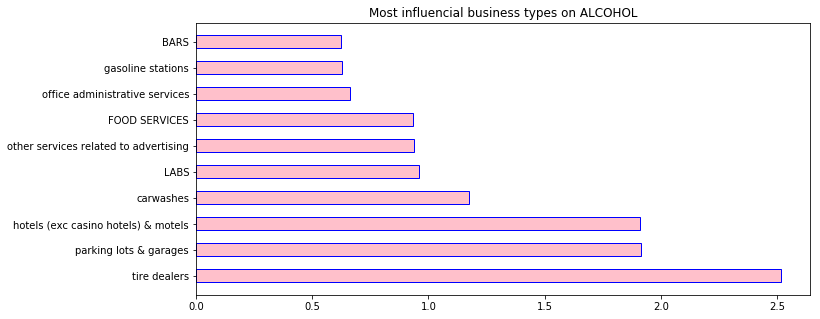

In [36]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=alcohol_near_business['offsetted_count'][:numbers_shown],
        tick_label=alcohol_near_business['ACTIVITY DESC'][:numbers_shown],
        color='pink',
        edgecolor='blue')

plt.title('Most influencial business types on ALCOHOL');

One approch we used is assume bussiness have a gravity like force that couses crime to happen around them. We than tried to find the magnatiud of this force for each business type.

We started by transforming each distance to its inverse squred

In [ ]:
weights_df = (1 / business_df) * (1 / business_df)

In [ ]:
weights_df.head()

We decided to divide our data by crime type to see if this force acts diffrently on alcoholic crimes vs fighting

In [ ]:
fight_df = weights_df.filter(like='fight')
alcoh_df = weights_df.filter(like='alcoh')

In [ ]:
fight_df.head()
fight_df.groupby(fight_df.index).sum()

In [ ]:
fight_df.index.value_counts()

In [ ]:
MASSAGE_df = weights_df.filter(like='MASSAGE THERAPY')
JANITORIAL_df = weights_df.filter(like='JANITORIAL SERVICES')

In [ ]:
JANITORIAL_df

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*